In [1]:
!pip install torchsummary

In [2]:
import torch
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class NetGroupNorm(nn.Module):
    def __init__(self, dropout_value=0.1):
        super(NetGroupNorm, self).__init__()
        num_groups = 4  # You can adjust the number of groups as needed

        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=3, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),  # Applying GroupNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 32/3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),  # Applying GroupNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16/6/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),  # Applying GroupNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),  # Applying GroupNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 16/14/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),  # Applying GroupNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),  # Applying GroupNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),  # Applying GroupNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),  # Applying GroupNorm with appropriate shape
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = NetGroupNorm().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 36, 36]             432
              ReLU-2           [-1, 16, 36, 36]               0
         GroupNorm-3           [-1, 16, 36, 36]              32
           Dropout-4           [-1, 16, 36, 36]               0
            Conv2d-5           [-1, 32, 36, 36]           4,608
              ReLU-6           [-1, 32, 36, 36]               0
         GroupNorm-7           [-1, 32, 36, 36]              64
           Dropout-8           [-1, 32, 36, 36]               0
            Conv2d-9           [-1, 16, 36, 36]             512
        MaxPool2d-10           [-1, 16, 18, 18]               0
           Conv2d-11           [-1, 32, 18, 18]           4,608
             ReLU-12           [-1, 32, 18, 18]               0
        GroupNorm-13           [-1, 32, 18, 18]              64
          Dropout-14           [-1

In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])

In [6]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:04<00:00, 42173590.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


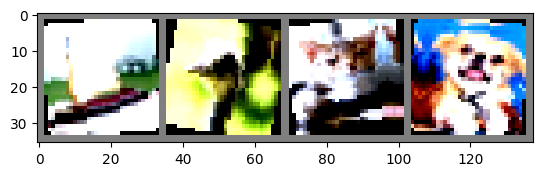

ship  bird  cat   dog  


In [10]:
 #functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []
    misclassified_targets = []
    misclassified_predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            misclassified_mask = pred.eq(target.view_as(pred)) == 0
            misclassified_images.append(data[misclassified_mask.view(-1)])  # Flatten the mask
            misclassified_targets.append(target[misclassified_mask.view(-1)])
            misclassified_predictions.append(pred[misclassified_mask.view(-1)])

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return misclassified_images, misclassified_targets, misclassified_predictions

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  NetGroupNorm().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    misclassified_images, misclassified_targets, misclassified_predictions = test(model, device, test_loader)

EPOCH: 0


Loss=1.812467336654663 Batch_id=97 Accuracy=28.29: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]



Test set: Average loss: 1.6981, Accuracy: 3802/10000 (38.02%)

EPOCH: 1


Loss=1.5400595664978027 Batch_id=97 Accuracy=39.85: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 1.4722, Accuracy: 4474/10000 (44.74%)

EPOCH: 2


Loss=1.4142175912857056 Batch_id=97 Accuracy=46.12: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]



Test set: Average loss: 1.4242, Accuracy: 4733/10000 (47.33%)

EPOCH: 3


Loss=1.3718560934066772 Batch_id=97 Accuracy=50.16: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]



Test set: Average loss: 1.2831, Accuracy: 5314/10000 (53.14%)

EPOCH: 4


Loss=1.269694447517395 Batch_id=97 Accuracy=53.34: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]



Test set: Average loss: 1.1933, Accuracy: 5650/10000 (56.50%)

EPOCH: 5


Loss=1.1001783609390259 Batch_id=97 Accuracy=55.86: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]



Test set: Average loss: 1.0713, Accuracy: 6121/10000 (61.21%)

EPOCH: 6


Loss=1.1302601099014282 Batch_id=97 Accuracy=57.93: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]



Test set: Average loss: 1.0726, Accuracy: 6196/10000 (61.96%)

EPOCH: 7


Loss=1.0930639505386353 Batch_id=97 Accuracy=59.99: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]



Test set: Average loss: 1.0534, Accuracy: 6240/10000 (62.40%)

EPOCH: 8


Loss=1.044360876083374 Batch_id=97 Accuracy=61.74: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 1.0207, Accuracy: 6302/10000 (63.02%)

EPOCH: 9


Loss=1.0314760208129883 Batch_id=97 Accuracy=62.80: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]



Test set: Average loss: 0.9238, Accuracy: 6692/10000 (66.92%)

EPOCH: 10


Loss=0.9921110272407532 Batch_id=97 Accuracy=63.72: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 0.9520, Accuracy: 6571/10000 (65.71%)

EPOCH: 11


Loss=0.9801944494247437 Batch_id=97 Accuracy=63.96: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]



Test set: Average loss: 0.9174, Accuracy: 6668/10000 (66.68%)

EPOCH: 12


Loss=1.0376920700073242 Batch_id=97 Accuracy=65.09: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 0.8954, Accuracy: 6828/10000 (68.28%)

EPOCH: 13


Loss=1.0214624404907227 Batch_id=97 Accuracy=65.23: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]



Test set: Average loss: 0.8622, Accuracy: 6971/10000 (69.71%)

EPOCH: 14


Loss=0.952468752861023 Batch_id=97 Accuracy=66.24: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]



Test set: Average loss: 0.8700, Accuracy: 6889/10000 (68.89%)

EPOCH: 15


Loss=0.9453662633895874 Batch_id=97 Accuracy=66.62: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 0.9070, Accuracy: 6835/10000 (68.35%)

EPOCH: 16


Loss=0.8766010999679565 Batch_id=97 Accuracy=67.28: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]



Test set: Average loss: 0.8717, Accuracy: 6996/10000 (69.96%)

EPOCH: 17


Loss=0.8225071430206299 Batch_id=97 Accuracy=68.07: 100%|██████████| 98/98 [00:28<00:00,  3.38it/s]



Test set: Average loss: 0.8179, Accuracy: 7055/10000 (70.55%)

EPOCH: 18


Loss=0.8721997141838074 Batch_id=97 Accuracy=68.44: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]



Test set: Average loss: 0.8265, Accuracy: 7069/10000 (70.69%)

EPOCH: 19


Loss=0.8863301873207092 Batch_id=97 Accuracy=68.70: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 0.7914, Accuracy: 7235/10000 (72.35%)



Text(0.5, 1.0, 'Test Accuracy')

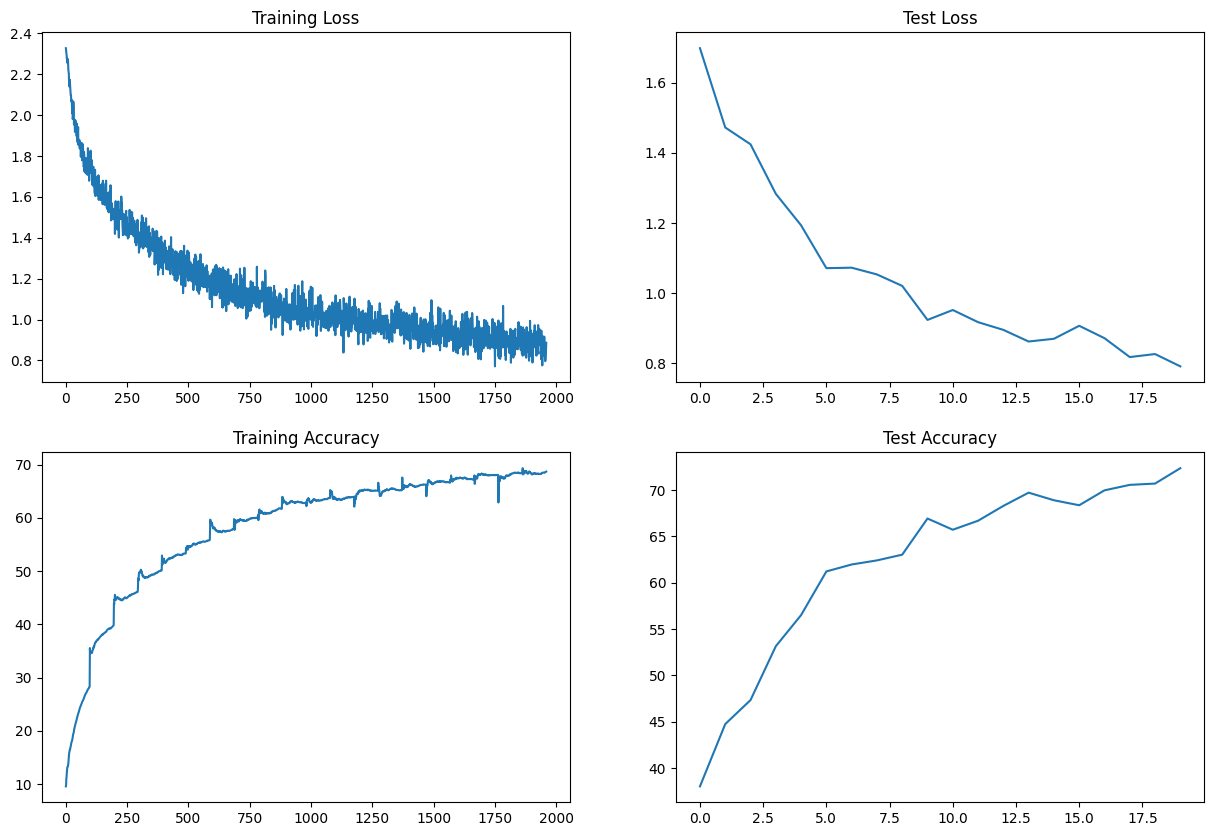

In [13]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

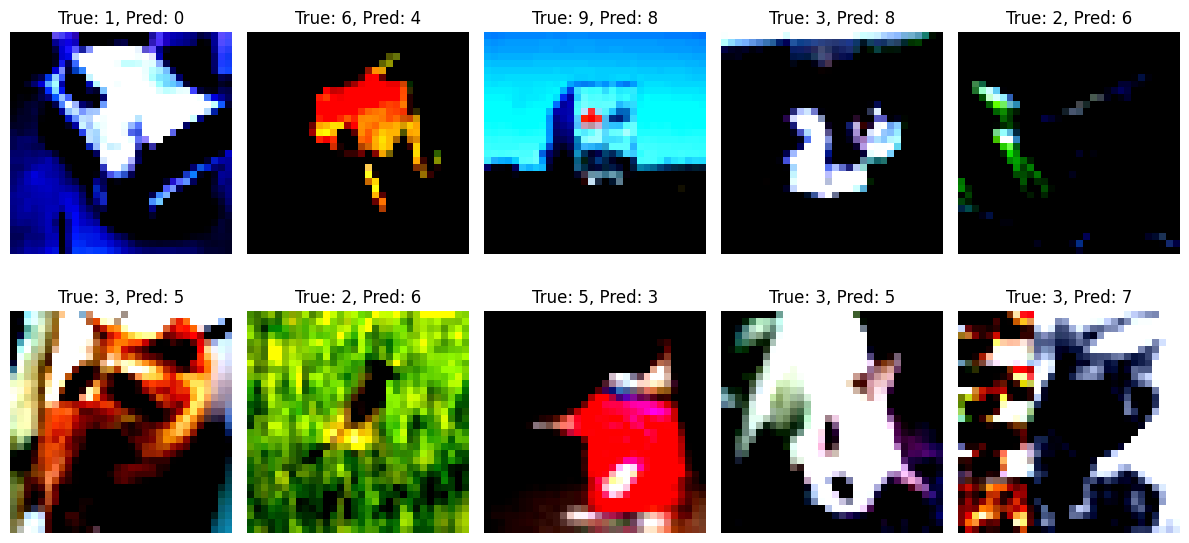

In [14]:

# Sample 10 misclassified images
num_samples = 10
sample_indices = np.random.choice(len(misclassified_images), min(num_samples, len(misclassified_images)), replace=False)

# Plot misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(sample_indices):
        ax.imshow(misclassified_images[sample_indices[i]][0].cpu().numpy().transpose((1, 2, 0)))
        ax.set_title(f"True: {misclassified_targets[sample_indices[i]][0].item()}, Pred: {misclassified_predictions[sample_indices[i]][0].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()

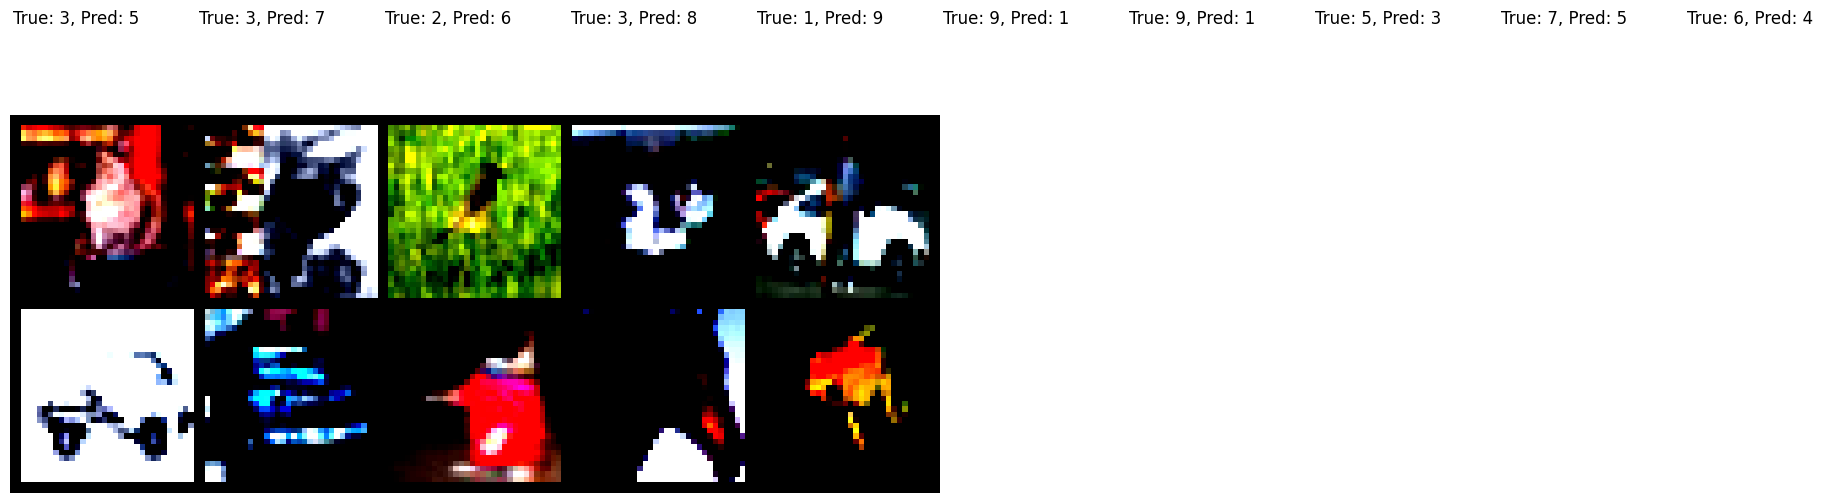

In [15]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Sample 10 misclassified images
num_samples = 10
sample_indices = torch.randperm(len(misclassified_images))[:min(num_samples, len(misclassified_images))]

# Prepare images and labels for plotting
images = [misclassified_images[idx][0].cpu() for idx in sample_indices]
labels_true = [misclassified_targets[idx][0].item() for idx in sample_indices]
labels_pred = [misclassified_predictions[idx][0].item() for idx in sample_indices]

# Plot misclassified images using torch grid
img_grid = make_grid(images, nrow=5)
plt.figure(figsize=(12, 6))
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())  # Move tensor to CPU and convert to numpy array
plt.axis('off')

# Add titles to each sub-image
for i in range(num_samples):
    plt.text(i * img_grid.shape[2] / 5, -20, f'True: {labels_true[i]}, Pred: {labels_pred[i]}', fontsize=12, ha='left', color='black', va='top', rotation=0)

plt.show()
